In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Projects_2023/MLHops/Depression_Tweets/notebooks
!ls

/content/drive/MyDrive/Projects_2023/MLHops/Depression_Tweets/notebooks
data_cleaning_exploration.ipynb  data_gathering_twint.py	   modeling.ipynb    old_models.py
data_cleaning_exploration.py	 data_gathering_twitter_API.ipynb  modeling.py	     testing.ipynb
data_gathering_twint.ipynb	 data_gathering_twitter_API.py	   old_models.ipynb  testing.py


In [ ]:
#!pip install -qqq h5py

In [ ]:
#!pip install --upgrade -qqq gensim

In [3]:
#This model is a large English language model that includes word vectors and is trained on a significant amount of text data
!python -m spacy download en_core_web_lg

2023-12-13 11:02:57.340877: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 11:02:57.340972: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 11:02:57.341018: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-13 11:02:57.357308: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-13 11:02:59.699714: W tensorflow/compiler/

In [ ]:
!pip install -U SpaCy==2.2.3

In [ ]:
!pip install keras==2.14.0


In [ ]:
## Import required libraries

## warnings
import warnings
warnings.filterwarnings("ignore")

## for data
import numpy as np
import pandas as pd

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

## T-Sne
from yellowbrick.text import TSNEVisualizer
from sklearn import manifold

## Train-Test Split
from sklearn.model_selection import train_test_split

## Feature selection
from sklearn import feature_selection

## libraraies for classification
from sklearn.pipeline import Pipeline
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

## for saving model
import pickle

## for explainer
#from lime import lime_text

## detokenization
from nltk.tokenize.treebank import TreebankWordDetokenizer

## for word embedding with gensim
import gensim
import gensim.downloader as gensim_api
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

## for word embedding with Spacy
import spacy
import en_core_web_lg

## for deep learning
from keras.models import load_model
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
import tensorflow as tf
import keras
from keras.layers import Lambda
import tensorflow as tf
from keras.models import model_from_json

## for bert language model
#import transformers

## Loading the dataset:

In [ ]:
df_all = pd.read_csv("/content/drive/MyDrive/MLHops/Depression_Tweets/data/processed_data.csv",
                     sep='\t', encoding='utf-8')

In [ ]:
df_all

,text,label,clean_text
0,Open discussion. Between the Transfer Portal a...,1,open discussion transfer portal nil become obs...
1,Plenty of things are changing in my life and t...,1,plenty thing changing life life around one thi...
2,I feel a little hopeless. Anyone else? #hopele...,1,feel little hopeless anyone else
3,"Which is more healthy? Hope, or hopelessness? ...",1,healthy hope hopelessness
4,So someone tell me how do I get over #HOPELESS...,1,someone tell get live world surrounded people ...
...,...,...,...
38904,"@andreaj27 well, cheers. i have a glass of wat...",0,well cheer glass water handy drink cheer
38905,@AndreaJo84 Is that right? You're over in Palm...,0,right palm spring guess see local news still w...
38906,@AndreaKobayashi It's the best cafe in Asakusa...,0,best cafe asakusa tokyo small serf best coffee
38907,@AndreaKoeln heeey! tonight is the night! no s...,0,heeey tonight night sleeping like night loll


## Classification models

In order to run a supervised learning model, we first need to convert the clean_text into feature representation.

In [ ]:
nlp = en_core_web_lg.load()

In [ ]:
## word-embedding
all_vectors = pd.np.array([pd.np.array([token.vector for token in nlp(s)]).mean(axis=0) * pd.np.ones((300)) \
                           for s in df_all['clean_text']])
## The word vectors are then averaged for each sentence

In [ ]:
# split out validation dataset for the end
Y= df_all["label"]
X = all_vectors

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
validation_size = 0.3
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# Setting up Cross-Validation Parameters
num_folds = 10
seed = 7
scoring = 'accuracy'

## List of algorithms
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))

In [ ]:
## Running the classification models
results = []
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=None)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    #msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    #print(msg)

   # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = accuracy_score(res.predict(X_train), Y_train)
    train_results.append(train_result)

# Training each model on the full training set and calculates accuracy on both the training and test sets
    # Test results
    test_result = accuracy_score(res.predict(X_test), Y_test)
    test_results.append(test_result)

    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)
    print(confusion_matrix(res.predict(X_test), Y_test))
    print(classification_report(res.predict(X_test), Y_test))

KNN: 0.789470 (0.008055) 0.844397 0.788915
[[4589  784]
 [1680 4620]]
              precision    recall  f1-score   support

           0       0.73      0.85      0.79      5373
           1       0.85      0.73      0.79      6300

    accuracy                           0.79     11673
   macro avg       0.79      0.79      0.79     11673
weighted avg       0.80      0.79      0.79     11673

SVM: 0.855926 (0.008651) 0.892422 0.854707
[[5543  970]
 [ 726 4434]]
              precision    recall  f1-score   support

           0       0.88      0.85      0.87      6513
           1       0.82      0.86      0.84      5160

    accuracy                           0.85     11673
   macro avg       0.85      0.86      0.85     11673
weighted avg       0.86      0.85      0.85     11673

RF: 0.822954 (0.008305) 0.998788 0.820012
[[5479 1311]
 [ 790 4093]]
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      6790
           1       0.76     

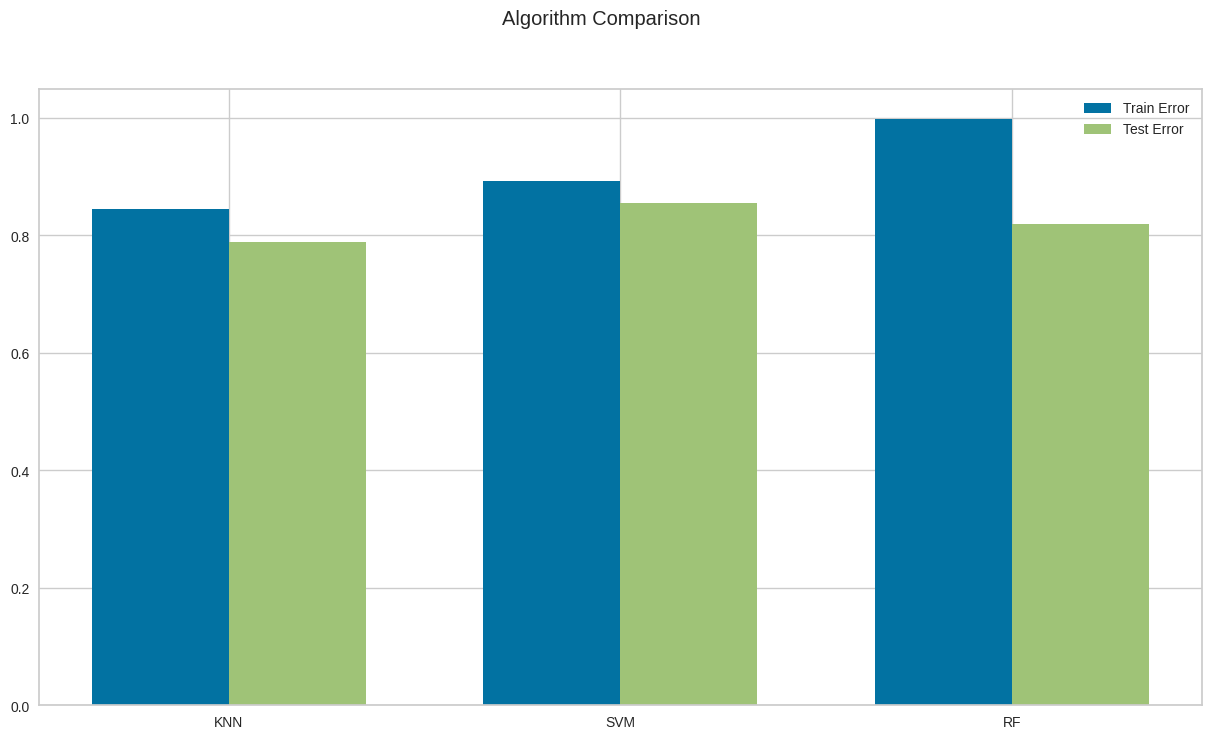

In [ ]:
# compare algorithms
from matplotlib import pyplot
fig = pyplot.figure()
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

The best model with the highest accuracy is **Support Vector Machine(SVM)** with **85.79**% accuracy on test dataset. Logistic Regression performed good as well but we see overfitting problem with CART, NN and RF.